In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

TAR_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)

ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 512.59it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8865.95it/s]


absolute alignment indicates number: 194 label diff indicates number: 13 confidence diff indicates number: 10 high distance number: 0


In [2]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,REF_PATH,TAR_PATH,TAR_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)

import torch
###### get border sample features
import torch.nn as nn

import os
ref_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(REF_EPOCH),
                                          "aligned_ref_border.npy")
tar_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
if os.path.exists(ref_border_path) and os.path.exists(tar_border_path):
    print("load positive boundary samples")
    ref_features = np.load(ref_border_path).squeeze()
    tar_features = np.load(tar_border_path).squeeze()

ref_neg_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_neg_border.npy")
tar_neg_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_neg_border.npy")
if os.path.exists(ref_neg_border_path) and os.path.exists(tar_neg_border_path):
     print("load negative boundary samples")
     ref_neg_features = np.load(ref_neg_border_path).squeeze()
     tar_neg_features = np.load(tar_neg_border_path).squeeze()

######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data_loader import DataLoaderInit
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)

from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8960.35it/s]

NET resnet18


Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8761.50it/s]


load positive boundary samples
load negative boundary samples


In [3]:
# model_loc = os.path.join(TAR_PATH, "Model", "Epoch_{}".format(TAR_EPOCH), "test_use_complex{}.pth".format(9))
model_loc = os.path.join(TAR_PATH, "Model", "Epoch_{}".format(TAR_EPOCH), "autoencoder{}.npy".format(9))
# model_loc = os.path.join(TAR_PATH,  "pre_autoencoder_withborder.npy")

# model_loc = os.path.join(TAR_PATH, "Model", "Epoch_{}".format(TAR_EPOCH), "test_use_complex_decoder{}.pth".format(1))
checkpoint = torch.load(model_loc)
autoencoder.load_state_dict(checkpoint['model_state_dict'])
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8775.06it/s]

#train# autoencoder PPR: 0.92 in epoch 200


0.91718

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8957.67it/s]


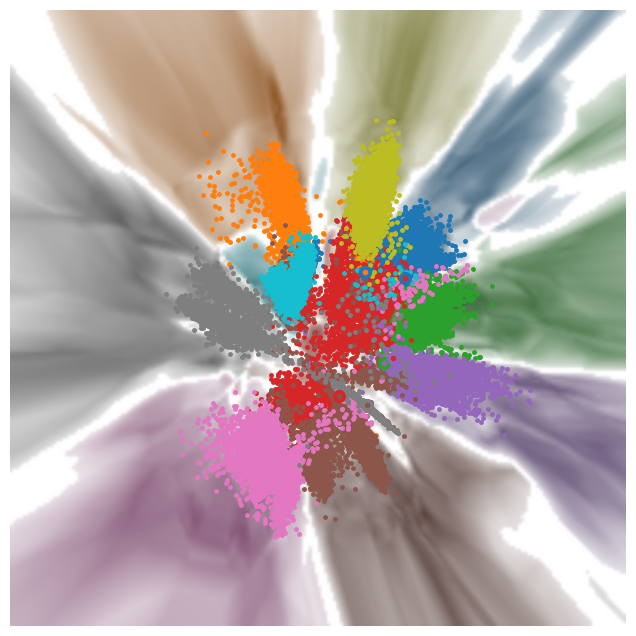

In [4]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "viit.png"))

In [5]:
eval.eval_nn_train_autoencoder(15, autoencoder)

Tue May 16 13:44:26 2023 Building RP forest with 16 trees
Tue May 16 13:44:27 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue May 16 13:44:48 2023 Building RP forest with 16 trees
Tue May 16 13:44:48 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.25/15 in epoch 200


1.254

In [11]:
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name="vis2", device="cpu")
ref_embdeeding = projector.batch_project(200, ref_provider.train_representation(REF_EPOCH))
inv = projector.batch_inverse(200, ref_embdeeding )
inv_pred = ref_provider.get_pred(200, inv).argmax(axis=1)

100%|██████████| 250/250 [00:00<00:00, 8774.84it/s]


In [12]:
curre = []
for i in range(len(inv_pred)):
    if inv_pred[i] == ref_prediction_res[i] :
        curre.append(i)

In [13]:
len(curre)

49140

In [14]:
num = 0
for i in range(len(predict_label_diff_indicates)):
    if predict_label_diff_indicates[i] in curre:
        num=num+1

In [15]:
num

5

In [16]:
len(predict_label_diff_indicates)

13

In [5]:
eval.eval_boundary_nn_autoencoder(tar_features,autoencoder,15)

#train# boundary preserving: 1.41/15 in epoch 200


1.40788

In [6]:


long_, short_, ref_prev, tar_prev = eval.eval_move_direction_preserving(autoencoder,10,1.5)


100%|██████████| 250/250 [00:00<00:00, 8579.20it/s]


long distance move subet number is 1299, short distance move set number is 1015


100%|██████████| 250/250 [00:00<00:00, 8675.52it/s]


all reference distance preserving 49919/50000
all target distance preserving 49839/50000
short distance move direction preserving 1003/1015
long distance move direction preserving 1292/1299


In [8]:
len(ref_prev) 

49409

In [ ]:
for i in range()

In [9]:
len(long_)

1554

In [7]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8876.76it/s]

refere  predction preserving:49140/50000 0.98
target  predction preserving:48737/50000 0.97
ref&tar pred_same preserving:48096/49987 0.96
ref&tar pred_diff preserving:7/13 0.54


In [4]:
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8861.46it/s]

#train# autoencoder PPR: 0.98 in epoch 200


0.97824

In [2]:
import os
ref_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
tar_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
if os.path.exists(ref_border_path) and os.path.exists(tar_border_path):
    print("aaa")
    ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
    ref_features = np.load(ref_border_centers_loc).squeeze()
    tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
    tar_features = np.load(tar_border_centers_loc).squeeze()

aaa


In [ ]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,REF_PATH,TAR_PATH,TAR_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=2000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

In [80]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_ref_in_ref(ref_neg_features, 15)

#train# boundary preserving: 1.43/15 in epoch 200


1.43006

In [ ]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_ppr_autoencoder(autoencoder)

In [ ]:
import os
ref_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
tar_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
if os.path.exists(ref_border_path) and os.path.exists(tar_border_path):
    print("aaa")
    ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
    ref_features = np.load(ref_border_centers_loc).squeeze()
    tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
    tar_features = np.load(tar_border_centers_loc).squeeze()

In [28]:
eval.eval_boundary_nn_ref_in_ref(ref_features, 15)

#train# boundary preserving: 1.29/15 in epoch 200


1.29498

In [29]:
import os
location_R = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_ref_border.npy")
location_T = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_tar_border.npy")
np.save(location_R, ref_features)
np.save(location_T, tar_features)

In [6]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)
c_y = encoded_Y.detach().numpy()

from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between  target vs target is:         ',np_cka.kernel_CKA(Y[indicates],Y[indicates]))
# print('CKA between target and linear_target:     ',np_cka.kernel_CKA(Y[indicates],np.dot(Y[indicates],R_n_2.detach().numpy())))
print('CKA between target and autoencoder_target:',np_cka.kernel_CKA(Y[indicates],c_y[indicates]))
print('CKA between  ref vs autoencoder_target is:',np_cka.kernel_CKA(X[indicates],c_y[indicates]))
print('CKA between  ref vs target is:            ',np_cka.kernel_CKA(X[indicates],c_y[indicates]))

CKA between  target vs target is:          1.0
CKA between target and autoencoder_target: 0.9986068054781738
CKA between  ref vs autoencoder_target is: 0.8835645488980813
CKA between  ref vs target is:             0.8835645488980813


In [12]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_ref_in_ref(ref_features, 15)
# eval.eval_boundary_nn_autoencoder(tar_border_centers, autoencoder)

#train# boundary preserving: 1.42/15 in epoch 200


1.4181

In [13]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

#train# boundary preserving: 1.67/15 in epoch 200


1.67374

In [14]:
eval.eval_nn_train_autoencoder(15,autoencoder)

Tue May 16 12:16:14 2023 Building RP forest with 16 trees
Tue May 16 12:16:14 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue May 16 12:16:16 2023 Building RP forest with 16 trees
Tue May 16 12:16:16 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.28/15 in epoch 200


1.27746

In [9]:
def eval_boundary_align_sensitivity(autoencoder, tar_b_features, ref_b_features):
        ############## init ###################
        #init target
        print("123")
        tar_b_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)
        tar_b_pred = tar_b_pred + 1e-8
        tar_sort_preds = np.sort(tar_b_pred, axis=1)
        tar_diff = (tar_sort_preds[:, -1] - tar_sort_preds[:, -2]) / (tar_sort_preds[:, -1] - tar_sort_preds[:, 0])
        tar_border = np.zeros(len(tar_diff), dtype=np.uint8) + 0.05
        tar_border[tar_diff < 0.15] = 1

        #init reference
        ref_b_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
        ref_b_pred = ref_b_pred + 1e-8
        ref_sort_preds = np.sort(ref_b_pred, axis=1)
        ref_diff = (ref_sort_preds[:, -1] - ref_sort_preds[:, -2]) / (ref_sort_preds[:, -1] - ref_sort_preds[:, 0])
        ref_border = np.zeros(len(ref_diff), dtype=np.uint8) + 0.05
        ref_border[ref_diff < 0.15] = 1
        
        ##### get all boundary list
        all_boundary_list = []
        
        for i in range(len(ref_border)):
            if ref_border[i] == 1 and tar_border[i] == 1:
                all_boundary_list.append(i)
        print(len(all_boundary_list))
        #### get ref low dimensional border
        ref_b_embedding = projector.batch_project(REF_EPOCH, ref_b_features)
        ref_b_inv = projector.batch_inverse(REF_EPOCH,ref_b_embedding)
        ref_b_pred_l = ref_provider.get_pred(REF_EPOCH, ref_b_inv)
        ref_b_pred_l = ref_b_pred_l  + 1e-8
        ref_sort_preds_l  = np.sort(ref_b_pred_l , axis=1)
        ref_diff_l  = (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, -2]) / (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, 0])
        ref_border_l = np.zeros(len(ref_diff_l), dtype=np.uint8) + 0.05
        ref_border_l[ref_diff_l < 0.15] = 1
        
        #### get target low dimensional border
        tar_b_embedding = projector.batch_project(REF_EPOCH, autoencoder.encoder(torch.Tensor(tar_b_features)).detach().numpy())
        tar_b_inv = projector.batch_inverse(REF_EPOCH,tar_b_embedding)
        tar_b_inv = autoencoder.decoder(torch.Tensor(tar_b_inv)).detach().numpy()
        tar_b_pred_l = tar_provider.get_pred(REF_EPOCH, tar_b_inv)
        tar_b_pred_l = tar_b_pred_l  + 1e-8
        tar_sort_preds_l  = np.sort(tar_b_pred_l , axis=1)
        tar_diff_l  = (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, -2]) / (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, 0])
        tar_border_l = np.zeros(len(tar_diff_l), dtype=np.uint8) + 0.05
        tar_border_l[tar_diff_l < 0.15] = 1

        all_boundary_list_l = []
       
        all_change = []
        all_change_l=[]
        ref_border_h = []
        ref_border_p =[]
        tar_border_h =[]
        tar_border_p= []
        for i in range(len(ref_border)):
            ##### low dimension all border
            if ref_border_l[i] == 1 and tar_border_l[i] == 1:
                all_boundary_list_l.append(i)
            if ref_border[i] != tar_border[i]:
                 all_change.append(i)
            if ref_border[i] != tar_border[i] and tar_border_l[i] == tar_border[i]:
                 all_change_l.append(i)
            if ref_border[i] == 1:
                 ref_border_h.append(i)
            if ref_border[i] == ref_border_l[i]:
                 ref_border_p.append(i)
            if tar_border[i] == 1:
                 tar_border_h.append(i)
            if tar_border[i] == tar_border_l[i]:
                 tar_border_p.append(i)
                 
                 
                 
           
        print("timevis sample preserving/ reference{}/{}".format(len(ref_border_p),len(ref_border_h)), len(ref_border_p) /len(ref_border))
        print("contravis sample preserving/ target{}/{}".format(len(tar_border_p),len(tar_border_h)), len(tar_border_p)/len(tar_border))
        print("boundary sample preserving{}/{}".format(len(all_boundary_list_l),len(all_boundary_list)))
        print("boundary change preserving{}/{}".format(len(all_change_l),len(all_change)))
       
eval_boundary_align_sensitivity(autoencoder,np.concatenate((tar_train_data,tar_features),axis=0), np.concatenate((ref_train_data,ref_features),axis=0))      

123


100%|██████████| 260/260 [00:00<00:00, 8448.20it/s]

2026



100%|██████████| 260/260 [00:00<00:00, 8523.41it/s]

timevis sample preserving/ reference47797/2300 0.9191730769230769
contravis sample preserving/ target47222/2288 0.9081153846153847
boundary sample preserving718/2026
boundary change preserving277/536


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8259.11it/s]


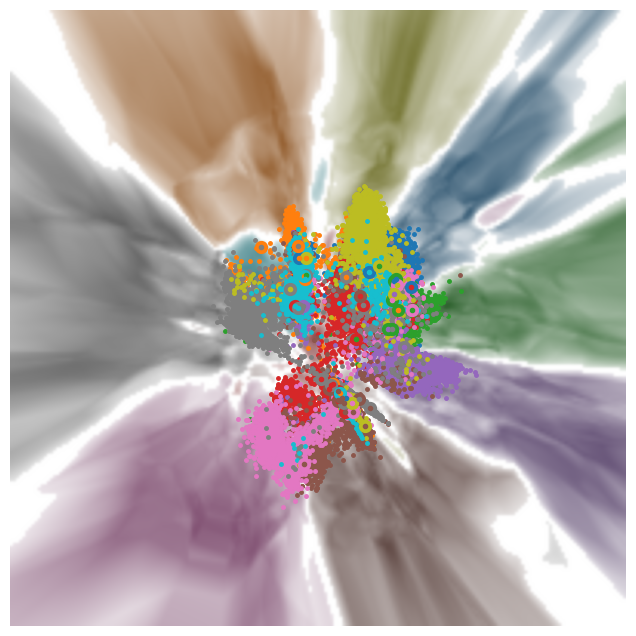

In [7]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'vis'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
###### use auto encoder to visualize the prediction
Y = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
X = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 4524.64it/s]


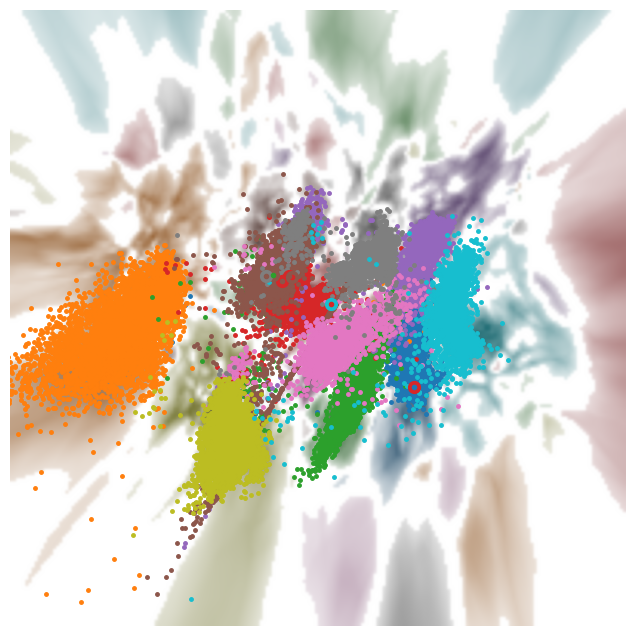

In [17]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'baseline'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, tar_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7735.31it/s]


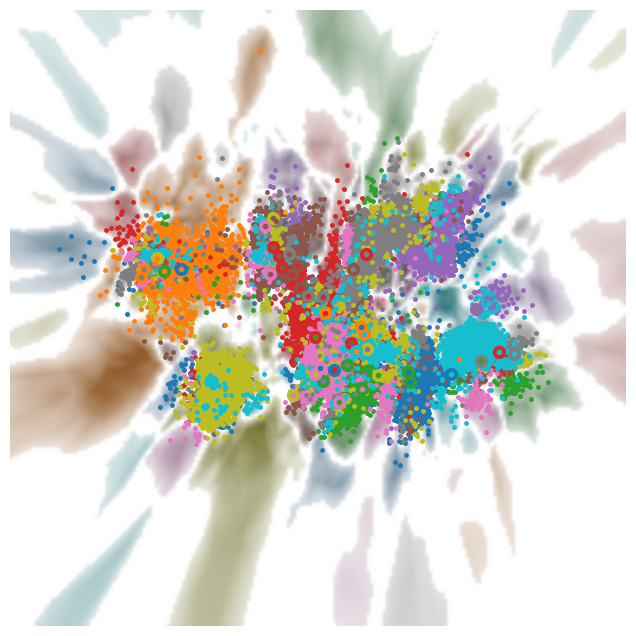

In [8]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVisAutoEncoder.visualizer_inv import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [40]:
from AlignVis.AlignSimilarityScaler import AlignSimilarityScaler

AlignSimilarity_scaler = AlignSimilarityScaler(REF_PATH, REF_PATH, TAR_PATH, TAR_PATH, 200,200, DEVICE)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8619.33it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8464.38it/s]
